In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from matplotlib.ticker import FormatStrFormatter
#from dataclasses import dataclass
from endstate_correction.constant import zinc_systems
from openmm.app import CharmmPsfFile, CharmmCrdFile, PDBFile
import pickle
import mdtraj as md
from numpy import interp
from endstate_correction.protocol import Protocol
from heapq import nsmallest, nlargest

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
# load results of the studied system

################################## ADJUST COMPOUND INFO & PATH ##################################
zinc_id, smiles, hp_id = zinc_systems[6]
nr_of_switches = 5000
results = pickle.load(open(f'/data/shared/projects/endstate_rew/{zinc_id}/switching/results_{nr_of_switches}.pickle', "rb"))
################################## ADJUST COMPOUND INFO & PATH  ##################################

# distinguish between NEQ and FEP
r_neq = results[0]
r_fep = results[1]

# check NEQ results 
print('Number of NEQ switches (MM to NNP): ', len(r_neq.W_mm_to_qml))
print('Number of NEQ switches (NNP to MM): ',len(r_neq.W_qml_to_mm))
print('Number of saved NEQ switching trajectories (MM to NNP): ', len(r_neq.switching_traj_mm_to_qml))
print('Number of saved NEQ switching trajectories (NNP to MM): ', len(r_neq.switching_traj_qml_to_mm))
print('Number of time steps of one switch (=switching length, MM to NNP): ', len(r_neq.switching_traj_mm_to_qml[0]))
print('Number of time steps of one switch (=switching length, NNP to MM): ', len(r_neq.switching_traj_qml_to_mm[0]))

Number of NEQ switches (MM to NNP):  500
Number of NEQ switches (NNP to MM):  500
Number of saved NEQ switching trajectories (MM to NNP):  500
Number of saved NEQ switching trajectories (NNP to MM):  500
Number of time steps of one switch (=switching length, MM to NNP):  5000
Number of time steps of one switch (=switching length, NNP to MM):  5000


In [3]:
# functions for inspecting NEQ switching work results

# find indices of lowest work values (used for plotting the corresponding conformations)
def find_smallest_list(w_list:list, nr_smallest:int):
    w_smallest= nsmallest(nr_smallest, w_list)
    print(w_smallest)
    indices = []
    for work in w_smallest:
        for i in range(500):
            if work == w_list[i]:
                print(f'index {i}:', w_list[i])
                indices.append(i)
    return indices

# find indices of highest work values (used for plotting the corresponding conformations)
def find_largest_list(w_list:list, nr_smallest:int):
    w_smallest= nlargest(nr_smallest, w_list)
    print(w_smallest)
    indices = []
    for work in w_smallest:
        for i in range(500):
            if work == w_list[i]:
                print(f'index {i}:', w_list[i])
                indices.append(i)
    return indices

# find the index of the Nth lowest work value (used for plotting the corresponding switching trajectory)
def find_smallest_nr(w_list:list, w_min_nr:int):
    w_list_smallest= nsmallest(w_min_nr, w_list)
    w_smallest = w_list_smallest[w_min_nr-1]
    print(w_smallest)
    for idx in range(500):
        if w_list[idx] == w_smallest:
            print(f'index {idx}')
            break
    return idx

# find work value of a specific index (not used for plotting, just for inspection)
def find_W(w_list:list, idx:int):
    # get work value of idx
    w = w_list[idx]
    w_list_smallest= nsmallest(500, w_list)
    for i in range(500):
        if w_list_smallest[i] == w:
            print(f'Work value {w} with index {idx} is the {i}. smallest work value')
            break

In [4]:
# get torsion scan results
def parse_energy_matrix(f):
    i,j = 0,0
    energy = np.zeros((60,60))
    for l in f.readlines():
        if 'Energy' in l:
            # convert hartree to kcal/mol
            #energy[i][j] = float(l.split(' ')[-1])*627.5
            # convert hartree to kT
            energy[i][j] = float(l.split(' ')[-1])*1059.70
            j += 1
            if j == 60:
                j = 0
                i += 1
    return energy

In [5]:
def write_pdb(hp_id: int):   
    # get name
    zinc_id, smiles, hp_id = zinc_systems[hp_id]
    
    ################################## ADJUST PATH ##################################
    path_to_psf = f"../../endstate_correction/data/hipen_data/{zinc_id}/{zinc_id}.psf"
    path_to_crd = f"../../endstate_correction/data/hipen_data/{zinc_id}/{zinc_id}.crd"
    ################################## ADJUST PATH ##################################
    
    psf = CharmmPsfFile(path_to_psf)
    coord = CharmmCrdFile(path_to_crd)

    with open("temp.pdb", "w") as outfile:
        PDBFile.writeFile(psf.topology, coord.positions, outfile)

In [6]:
# compute torsions from sampling data
def compute_torsions_sampling(w_dir: str, chi_1_indices:list, chi_2_indices:list):
    
    coordinates = []
    print('loading sampling file...')
    coord = pickle.load(open(f"{w_dir}.pickle", "rb"))
    # remove first 1k samples
    coordinates = coord[1000:]
    print(f'number of sampling data: {len(coordinates)}')
    print('computing torisons for sampling data...')
    # load topology from pdb file
    top = md.load("temp.pdb").topology
    # generate trajectory instance 
    traj = md.Trajectory(xyz=coordinates, topology=top)
    # compute dihedrals
    torsions = md.compute_dihedrals(traj, [chi_1_indices, chi_2_indices], periodic=True, opt=True)
    
    return torsions

# compute torsions from switching data
def compute_torsions_switching(results:Protocol, 
                               data_type: str, # 'start': get starting conformations; 'trajectory': get trajectory conformations; 'endstate': get endstate conformations
                               chi_1_indices:list, 
                               chi_2_indices:list
                               ):
    coordinates = []
    if data_type == 'start':
        for switch in results:
            # get coordinates before the first switch
            coordinates.append(switch[0]) 
        print(f'number of start conformations: {len(coordinates)}')
        print('computing torsions for starting conformations...')
    elif data_type == 'trajectory':
        coordinates = results
        print(f'number of conformations in switching trajectory: {len(coordinates)}')
        print('computing torsions for starting conformations...')
        print('number of endstate switching conformations selected for computing torsions:', len(coordinates))
    elif data_type == 'endstate':
        for switch in results:
            # get coordinates of the last switch
            coordinates.append(switch[-1]) 
        print(f'number of conformations in switching trajectory: {len(coordinates)}')
        print('computing torsions for starting conformations...')
        print('number of endstate switching conformations selected for computing torsions:', len(coordinates))
    
    # load topology from pdb file
    top = md.load("temp.pdb").topology
    # generate trajectory instance 
    traj = md.Trajectory(xyz=coordinates, topology=top)
    # compute dihedrals
    torsions = md.compute_dihedrals(traj, [chi_1_indices, chi_2_indices], periodic=True, opt=True)
        
    return torsions

In [24]:
def torsion_plot(mol: int, # nr of compound in the zinc_systems list
                        r_neq: Protocol, # NEQ switching results
                        chi_1_indices:list, # four atom indices of first torsion
                        chi_2_indices:list, # four atom indices of second torsion
                        swi_len: int, # switching length
                        dir_mm: str, # directory, where torsion scan data is located (MM)
                        dir_qml:str, # directory, where torsion scan data is located (QML)
                        w_min_nr: str, # the Nth smallest work value; '1' is the smallest (uesd to plot the corresponding switching trajectory)
                        start: bool = False, # if True, starting conformations will be plotted
                        trajectory: bool = False, # if True, switching trajectory (which produces the lowest work value) will be plotted
                        endstate: bool = False, # if True, final conformations will be plotted
                        idx_spec: bool = False, # if True, a specific trajectory (instead of the one producint the lowest work value) will be plotted
                        idx_spec_mm_to_qml:str = 0, # in combination with idx_spec=True: indicate a specific MM->QML trajectory
                        idx_spec_qml_to_mm:str = 0, # in combination with idx_spec=True: indicate a specific QML->MM trajectory
                        n_smallest: bool =False, # if True, mark the 5 lowest work values 
                        n_largest: bool = False, # if True, mark the 5 highest work values
                        figure_title: str = '' # figure title
                        ):
    
    write_pdb(hp_id=mol)
    
    # get name
    zinc_id, smiles, hp_id = zinc_systems[mol]
    print('Plotting torsion scan of: ', zinc_id, hp_id)
    print('------------------------------------------------------------------------------------')

    ###############################################################################################################################################################################
    ######################################################################### COMPUTE TORSIONS ####################################################################################
    ###############################################################################################################################################################################
    
    #--------------------------------------------------------------------------- SAMPLING DATA -----------------------------------------------------------------------------------#

    # compute dihedrals only if 4 indices have been indicated
    if len(chi_1_indices) == 4 and len(chi_2_indices) == 4:
        
        # define lists for sampling data
        runs = ["run01", "run02", "run03"]
        data_mm = []
        data_qml = []
        
        # get sampling data from all runs and compute sampled torsions
        for run in runs:
            print('---', run, '---')
            ################################## ADJUST PATH ##################################
            print('MM sampling data:')
            data_mm.extend(compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/{run}/{zinc_id}_samples_5000_steps_1000_lamb_0.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi)
            print('QML sampling data:')
            data_qml.extend(compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/{run}/{zinc_id}_samples_5000_steps_1000_lamb_1.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi)
            ################################## ADJUST PATH ##################################                                        
        # convert to array
        sampling_mm = np.array(data_mm)
        sampling_qml = np.array(data_qml)
        print('------------------------------------------------------------------------------------')
        #------------------------------------------------------------------------ SWITCHING DATA ----------------------------------------------------------------------------------#
        # compute torsions of starting contormations
        if start:
            print('switching data (MM to QML):')
            start_mm_to_qml = compute_torsions_switching(results=r_neq.switching_traj_mm_to_qml,
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices, 
                                                        data_type = "start")*180/np.pi
            print('switching data (QML to MM):')                                            
            start_qml_to_mm = compute_torsions_switching(results=r_neq.switching_traj_qml_to_mm,
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices, 
                                                        data_type = "start")*180/np.pi
            
        # compute torsions for switching trajectory (either a specific one or the one yielding the smallest work value)
        if trajectory:
            if idx_spec:
                # indices of specific trajectory
                idx_mm_to_qml = idx_spec_mm_to_qml
                idx_qml_to_mm = idx_spec_qml_to_mm
            else:
                # get indices of Nth smallest work values
                idx_mm_to_qml = find_smallest_nr(w_list = r_neq.W_mm_to_qml, w_min_nr=w_min_nr)
                idx_qml_to_mm = find_smallest_nr(w_list = r_neq.W_qml_to_mm, w_min_nr=w_min_nr)

            # compute torsions
            print('switching data (MM to QML):')
            traj_mm_to_qml = compute_torsions_switching(results=r_neq.switching_traj_mm_to_qml[idx_mm_to_qml],
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices, 
                                                        data_type = "trajectory")*180/np.pi
            print('switching data (QML to MM):')  
            traj_qml_to_mm =  compute_torsions_switching(results=r_neq.switching_traj_qml_to_mm[idx_qml_to_mm],
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices, 
                                                        data_type = "trajectory")*180/np.pi
            
        # compute torsions for final switching conformations   
        if endstate:
            print('switching data (MM to QML):')
            endstate_mm_to_qml = compute_torsions_switching(results=r_neq.switching_traj_mm_to_qml,
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices, 
                                                        data_type = "endstate")*180/np.pi
            print('switching data (QML to MM):')  
            endstate_qml_to_mm =  compute_torsions_switching(results=r_neq.switching_traj_qml_to_mm,
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices, 
                                                        data_type = "endstate")*180/np.pi                                                   
        print('------------------------------------------------------------------------------------')                                      
            
    ###############################################################################################################################################################################
    ######################################################################### PLOT DATA  ##########################################################################################
    ###############################################################################################################################################################################
            
        #-------------------------------------------------------------- SUMMARIZE DATA & LABELS ----------------------------------------------------------------------------------#
        # for plotting only sampling data
        if not endstate and not start:
            figure_data = [[sampling_mm], [sampling_qml]]
            figure_labels = [[r'$\{\chi_1, \chi_2\}$'], [r'$\{\chi_1, \chi_2\}$']]
        # for plotting final conformations
        if endstate and not start:
            figure_data = [[sampling_mm, endstate_qml_to_mm], [sampling_qml, endstate_mm_to_qml]]
            figure_labels = [[r'$\{\chi_1, \chi_2\}$', r'$\{\chi_1, \chi_2\}^{t=\tau}$'], [r'$\{\chi_1, \chi_2\}$', r'$\{\chi_1, \chi_2\}^{t=\tau}$']]
        # for plotting starting conformations
        if start and not endstate:
            figure_data = [[sampling_mm, start_mm_to_qml], [sampling_qml, start_qml_to_mm]]
            figure_labels = [[r'$\{\chi_1, \chi_2\}$', r'$\{\chi_1, \chi_2\}^{t=0}$'], [r'$\{\chi_1, \chi_2\}$', r'$\{\chi_1, \chi_2\}^{t=0}$']]
   
        # directories for torsion scans
        torsion_scans = [f'{dir_mm}/scan-final.xyz', f'{dir_qml}/scan-final.xyz']
        

        #--------------------------------------------------------------------------- PLOT ----------------------------------------------------------------------------------------#
        # define 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(13.2,6), dpi=600)  
        # define position of colorbar
        cbar_ax = fig.add_axes([.91, .11, .09, .77]) 

        # figure 0 is the MM plot, figure 1 the QML plot
        for figure in [0,1]:
            
            #-----------------------------------------------------------------  TORSION SCAN RESULTS ------------------------------------------------------------------------------#
            energy = parse_energy_matrix(open(torsion_scans[figure]))
            plot_e = energy.flatten()

            # compute difference between highest and lowest energy value
            delta = np.max(plot_e) - np.min(plot_e)
            print('E min: ', np.min(plot_e), 'kT')
            print('E max: ',np.max(plot_e), 'kT')
            if figure == 0:
                ediff_1 = round(delta, 1)
                print('dE MM torsion scan: ', ediff_1, 'kT')
            elif figure == 1:
                ediff_2 = round(delta,1)
                print('dE QML torsion scan: ', ediff_2, 'kT')
            
            # define color palette for heatmap
            heatmap_palette = sns.color_palette("blend:#ffffd4,#fee391,#fac428,#ff9927,#ff7931,#ff5d05,#f91c00", as_cmap=True)

            # plot results of torsion scan
            plotting = sns.heatmap(energy, 
                                    annot=False, 
                                    cmap=heatmap_palette,
                                    ax= axs[figure], 
                                    cbar=figure == 0, 
                                    cbar_kws={'label':r'$\Delta$U [$k_BT$]', 'ticks':[]},
                                    cbar_ax=None if figure else cbar_ax # remove colorbars from individual plots
                                    )
            cbar_ax.yaxis.label.set_size(19)

            # plot black frame around heatmaps
            plotting.axhline(y = 0, color = 'k', linewidth = 3)
            plotting.axhline(y = 60, color = 'k', linewidth = 3)
            plotting.axvline(x = 0, color = 'k', linewidth = 3)
            plotting.axvline(x = 60, color = 'k', linewidth = 3)

            #--------------------------------------------------------------------------- SAMPLING ----------------------------------------------------------------------------------------#
            axs[figure].scatter(interp(figure_data[figure][0][:, 1], [-180,180],[0,60]), 
                                interp(figure_data[figure][0][:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'yellowgreen',  
                                alpha = 1, 
                                label = figure_labels[figure][0])

            # this part can be used for plotting only the sampling data (each 'run' in a different color)
            """ # RUN 1
            data_mm = compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/run01/{zinc_id}_samples_5000_steps_1000_lamb_0.0000", 
                                                        chi_1_indices=chi_1_indices, 
                                                        chi_2_indices=chi_2_indices)*180/np.pi
            axs[0].scatter(interp(data_mm[:, 1], [-180,180],[0,60]), 
                                interp(data_mm[:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'yellowgreen',  
                                alpha = 1, 
                                label = 'run 1')
            data_qml = compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/run01/{zinc_id}_samples_5000_steps_1000_lamb_1.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi 
            axs[1].scatter(interp(data_qml[:, 1], [-180,180],[0,60]), 
                                interp(data_qml[:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'yellowgreen',  
                                alpha = 1, 
                                label = 'run 1')
            # RUN 2
            data_mm = compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/run02/{zinc_id}_samples_5000_steps_1000_lamb_0.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi
            axs[0].scatter(interp(data_mm[:, 1], [-180,180],[0,60]), 
                                interp(data_mm[:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'magenta',  
                                alpha = 1, 
                                label = 'run 2')
            data_qml = compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/run02/{zinc_id}_samples_5000_steps_1000_lamb_1.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi
            axs[1].scatter(interp(data_qml[:, 1], [-180,180],[0,60]), 
                                interp(data_qml[:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'magenta',  
                                alpha = 1, 
                                label = 'run 2')
            # RUN 3
            data_mm = compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/run03/{zinc_id}_samples_5000_steps_1000_lamb_0.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi
            axs[0].scatter(interp(data_mm[:, 1], [-180,180],[0,60]), 
                                interp(data_mm[:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'darkblue',  
                                alpha = 1, 
                                label = 'run 3')
            data_qml = compute_torsions_sampling(w_dir=f"/data/shared/projects/endstate_rew/{zinc_id}/sampling_charmmff/run03/{zinc_id}_samples_5000_steps_1000_lamb_1.0000", 
                                                    chi_1_indices=chi_1_indices, 
                                                    chi_2_indices=chi_2_indices)*180/np.pi
            axs[1].scatter(interp(data_qml[:, 1], [-180,180],[0,60]), 
                                interp(data_qml[:, 0], [-180,180],[0,60]),
                                marker = '.', 
                                s= 30, 
                                color = 'darkblue',  
                                alpha = 1, 
                                label = 'run 3') """
            #-------------------------------------------------------------------------- SWITCHING ----------------------------------------------------------------------------------------#
            if endstate:
                axs[figure].scatter(interp(figure_data[figure][1][:, 1], [-180,180],[0,60]),
                                    interp(figure_data[figure][1][:, 0], [-180,180],[0,60]),
                                    marker = '.', 
                                    s= 30, 
                                    color = 'royalblue', 
                                    alpha = 1, 
                                    label = figure_labels[figure][1])
            #-------------------------------------------------------------------- STARTING CONFORMATIONS ---------------------------------------------------------------------------------#
            if start:
                axs[figure].scatter(interp(figure_data[figure][1][:, 1], [-180,180],[0,60]), 
                                    interp(figure_data[figure][1][:, 0], [-180,180],[0,60]), 
                                    marker = '.', 
                                    s= 50, 
                                    facecolors = 'None', 
                                    edgecolors = 'royalblue',
                                    linewidth= 1.2,
                                    alpha = 1, 
                                    label = figure_labels[figure][1])
            #------------------------------------------------------------------------- PLOT STYLE ---------------------------------------------------------------------------------------#
            # torsion labels
            axs[figure].set_ylabel(rf'$\chi_{1}$', fontsize=19)
            axs[figure].set_xlabel(rf'$\chi_{2}$', fontsize=19)
            
            # set ticks
            ticks = [i for i in np.linspace(0, 60, 10)]
            axs[figure].set_xticks(ticks)
            axs[figure].set_yticks(ticks)
            axs[figure].tick_params(left=True, bottom=True)

            interval = [str(int(i)) for i in np.linspace(-180, 180, 10)]
            axs[figure].set_xticklabels(interval, fontsize= 19)
            axs[figure].set_yticklabels(interval, fontsize= 19)
            axs[figure].invert_yaxis()

        
        #-------------------------------------------------------------------- TRAJECTORIES ---------------------------------------------------------------------------------#
        
        qml_to_mm_color = [i/5000 for i in range(5000)]
        qml_to_mm_color.reverse()
        mm_to_qml_color = [i/5000 for i in range(5000)]

        if trajectory:
            # color palette for trajectory 
            palette = sns.color_palette("blend:yellowgreen,royalblue", as_cmap=True)
            # plot mm to qml trajectory in mm plot
            axs[0].scatter(interp(traj_mm_to_qml[:, 1], [-180,180],[0,60]), 
                            interp(traj_mm_to_qml[:, 0], [-180,180],[0,60]), 
                            marker = '.', 
                            s= 120, 
                            c = mm_to_qml_color, 
                            cmap = palette,
                            linewidth = 0.5,
                            edgecolors= 'black', 
                            alpha = 1)
            # plot qml to mm trajectory in qml plot
            axs[1].scatter(interp(traj_qml_to_mm[:, 1], [-180,180],[0,60]), 
                            interp(traj_qml_to_mm[:, 0], [-180,180],[0,60]), 
                            marker = '.',
                            s= 120, 
                            c = qml_to_mm_color,
                            cmap = palette,
                            linewidth = 0.5,
                            edgecolors= 'black', 
                            alpha = 1)
        
            # plot start of mm to qml trajectory
            axs[0].scatter(interp(traj_mm_to_qml[0, 1], [-180,180],[0,60]), 
                            interp(traj_mm_to_qml[0, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                            s= 200, 
                            facecolors = 'yellowgreen', 
                            edgecolors = 'black', 
                            alpha = 1, 
                            linewidth = 1.5,
                            #label = r'start MM$\rightarrow$QML')
                            label = r'$(\chi_1, \chi_2)^{t=0}$')
            # plot end of mm to qml trajectory 
            axs[0].scatter(interp(traj_mm_to_qml[-1, 1], [-180,180],[0,60]), 
                            interp(traj_mm_to_qml[-1, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                            s= 200, 
                            facecolors = 'cornflowerblue', 
                            edgecolors = 'black', 
                            alpha = 1, 
                            linewidth = 1.5,
                            label = r'$(\chi_1, \chi_2)^{t=\tau}$')

            # plot start of qml to mm trajectory
            axs[1].scatter(interp(traj_qml_to_mm[0, 1], [-180,180],[0,60]), 
                            interp(traj_qml_to_mm[0, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                            s= 200, 
                            facecolors = 'yellowgreen', 
                            edgecolors = 'black', 
                            alpha = 1, 
                            linewidth = 1.5,
                            label = r'$(\chi_1, \chi_2)^{t=0}$')
            # plot end of qml to mm trajectory 
            axs[1].scatter(interp(traj_qml_to_mm[-1, 1], [-180,180],[0,60]), 
                            interp(traj_qml_to_mm[-1, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                            s= 200, 
                            facecolors = 'cornflowerblue', 
                            edgecolors = 'black', 
                            alpha = 1, 
                            linewidth = 1.5,
                            label = r'$(\chi_1, \chi_2)^{t=\tau}$')

        #-------------------------------------------------------------------- MARK SPECIFIC CONFORMATIONS ---------------------------------------------------------------------------------#

        # mark the N smallest work values    
        if n_smallest:
            find_smallest_list(r_neq.W_mm_to_qml, 5)
            # color qml -> mm switches, which result in smallest work values in red
            for i in find_smallest_list(w_list=r_neq.W_qml_to_mm, nr_smallest=5):
                axs[0].scatter(interp(figure_data[0][1][i, 1], [-180,180],[0,60]), 
                            interp(figure_data[0][1][i, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                                s= 200, 
                                facecolors = 'red', 
                                edgecolors = 'black',
                                linewidth= 1, 
                            alpha = 1)#, label = figure_labels[1][0])
        
            find_smallest_list(r_neq.W_qml_to_mm, 5)
            # color mm -> qml switches, which result in smallest work values in red
            for i in find_smallest_list(w_list=r_neq.W_mm_to_qml, nr_smallest=5):
                axs[1].scatter(interp(figure_data[1][1][i, 1], [-180,180],[0,60]), 
                            interp(figure_data[1][1][i, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                                s= 200, 
                                facecolors = 'red', 
                                edgecolors = 'black',
                                linewidth= 1, 
                            alpha = 1)#, label = figure_labels[1][0])
                
        # mark the N largest work values   
        if n_largest:
            find_largest_list(r_neq.W_mm_to_qml, 5)
            # color mm -> qml switches, which result in smallest work values in red
            for i in find_largest_list(w_list=r_neq.W_mm_to_qml, nr_smallest=5):
                axs[1].scatter(interp(figure_data[1][1][i, 1], [-180,180],[0,60]), 
                            interp(figure_data[1][1][i, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                                s= 200, 
                                facecolors = 'red', 
                                edgecolors = 'black',
                                linewidth= 1, 
                            alpha = 1)

            find_largest_list(r_neq.W_qml_to_mm, 5)
            # color qml -> mm switches, which result in smallest work values in red
            for i in find_largest_list(w_list=r_neq.W_qml_to_mm, nr_smallest=5):
                axs[0].scatter(interp(figure_data[0][1][i, 1], [-180,180],[0,60]), 
                            interp(figure_data[0][1][i, 0], [-180,180],[0,60]), 
                            marker = 'X', 
                                s= 200, 
                                facecolors = 'red', 
                                edgecolors = 'black',
                                linewidth= 1, 
                            alpha = 1)
        
        # add legend
        axs[0].legend(loc = 'best', fontsize = 19, markerscale = 1) # markerscale = 2
        axs[1].legend(loc = 'best', fontsize = 19, markerscale = 1) # markerscale = 2

        axs[0].set_title('MM', fontsize = 19) 
        axs[1].set_title('NNP', fontsize = 19)
        
        fig.suptitle(figure_title, fontsize = 19)
        fig.savefig(f'torsion_scan_{hp_id}_{swi_len}.svg')

    else:
        print(f"Four indices needed to define a dihedral angle. The current list of phi indices contains {len(chi_1_indices)} entries; the list of psi indices contains {len(chi_2_indices)} entries.")


Plotting torsion scan of:  ZINC00107550 hp7
------------------------------------------------------------------------------------
--- run01 ---
MM sampling data:
loading sampling file...
number of sampling data: 4000
computing torisons for sampling data...
QML sampling data:
loading sampling file...
number of sampling data: 4000
computing torisons for sampling data...
--- run02 ---
MM sampling data:
loading sampling file...
number of sampling data: 4000
computing torisons for sampling data...
QML sampling data:
loading sampling file...
number of sampling data: 4000
computing torisons for sampling data...
--- run03 ---
MM sampling data:
loading sampling file...
number of sampling data: 4000
computing torisons for sampling data...
QML sampling data:
loading sampling file...
number of sampling data: 4000
computing torisons for sampling data...
------------------------------------------------------------------------------------
-560520.0062574989
index 48
560514.6463290226
index 90
switchin

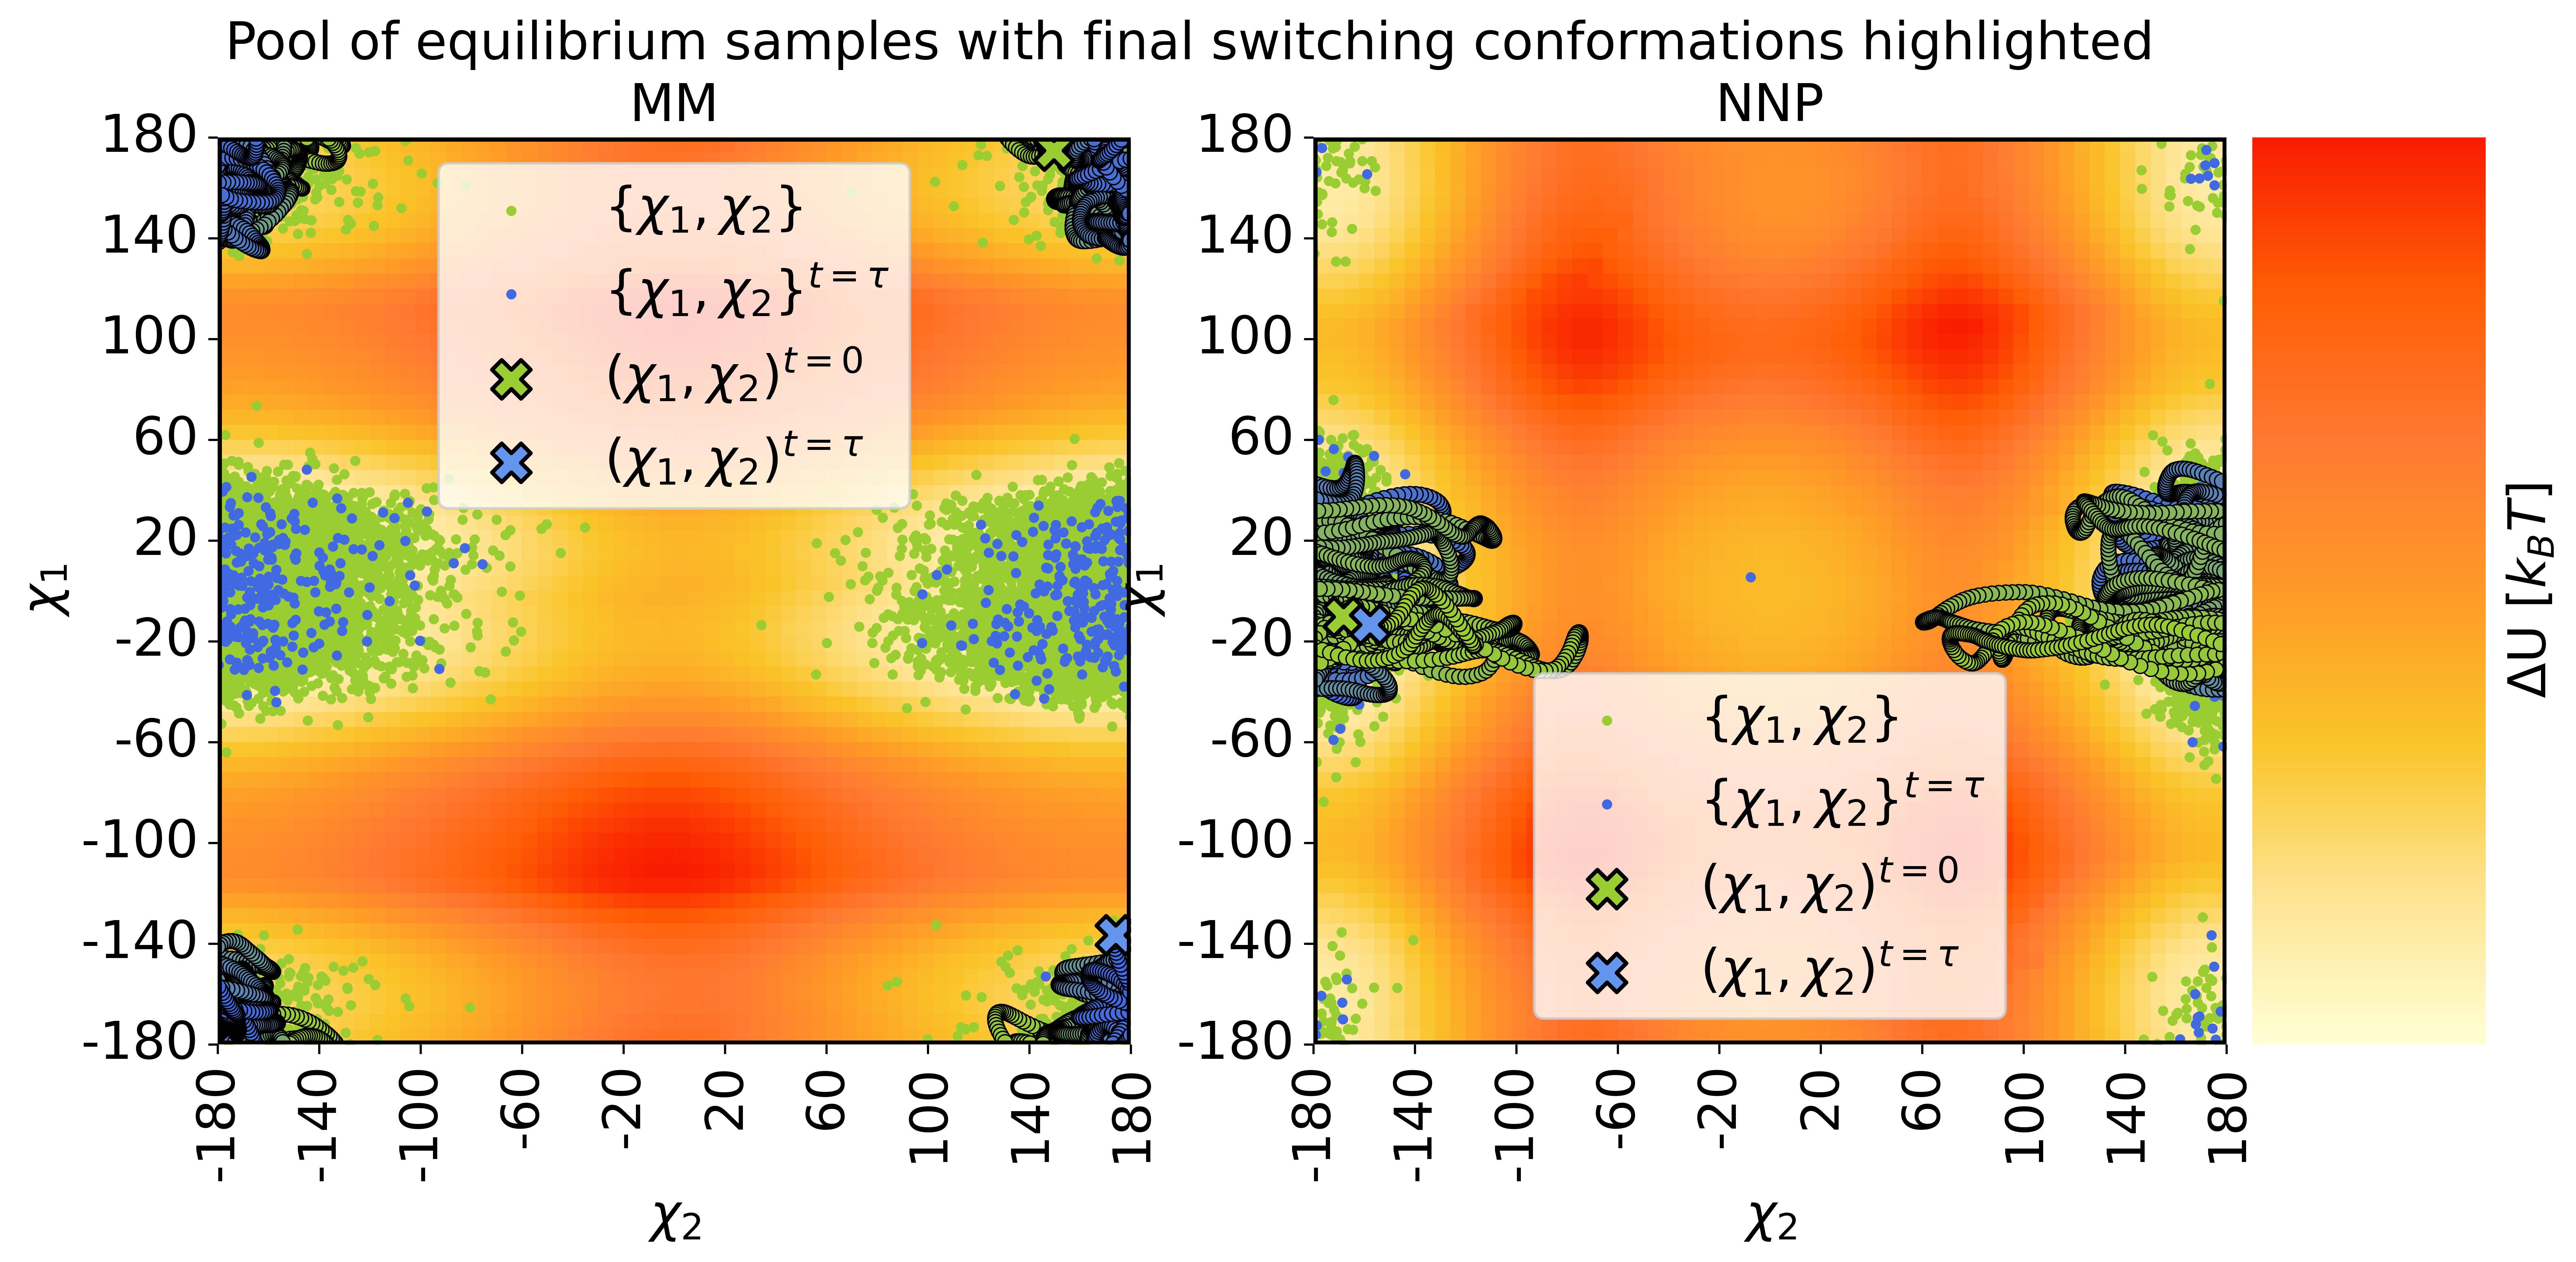

In [27]:
torsion_plot(mol = 6, 
                r_neq = r_neq,
                chi_1_indices=[1,2,7,8], #hp2: [5,4,6,14], hp8: [21,13,12,11],
                chi_2_indices=[7,8,9,17], #hp2: [6,7,8,15], hp8: [7,8,11,20],
                swi_len=5001, 
                dir_mm='/home/stkaczyk/endstate_correction/endstate_correction/data/torsion-scans/torsion_scan_geometrics_hp7_torsion_2_3_8_9_and_8_9_10_18_openMM', 
                dir_qml='/home/stkaczyk/endstate_correction/endstate_correction/data/torsion-scans/torsion_scan_geometrics_hp7_torsion_2_3_8_9_and_8_9_10_18_ani2x',
                start = False,
                trajectory = True,
                endstate = True,
                w_min_nr= 1, 
                idx_spec = False,
                #idx_spec_mm_to_qml= 377,
                #idx_spec_qml_to_mm = 364,
                n_smallest = False,
                n_largest = False,
                figure_title='Pool of equilibrium samples with final switching conformations highlighted' # 'Pool of equilibrium samples with initial switching conformations highlighted', 'Pool of equilibrium samples with lowest work switching trajectory highlighted'
                )
